# Real-Business Cycle Model with Search and Matching (Andolfatto, 1996)

Step-by-step implementation of the RBC model

## 1. Real Business Cycle (RBC) style model with endogenous labor supply.

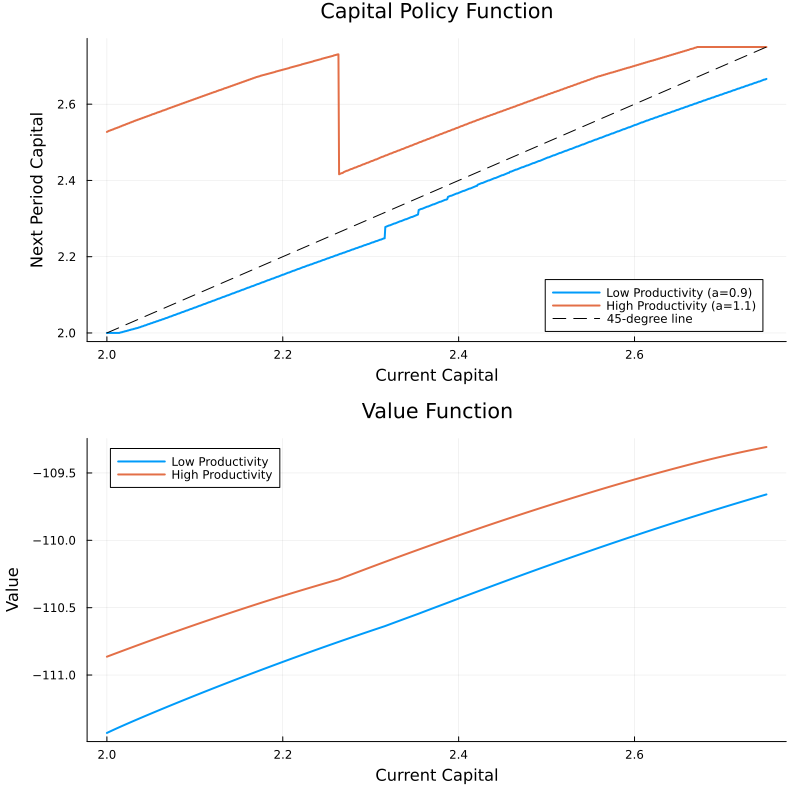

"/home/tarikz/git-projects/econmediadb/jupyterlab/model_results.png"

In [9]:
using Plots
using LinearAlgebra

# Use a struct for parameters to avoid global scope issues
struct ModelParams
    β::Float64; α::Float64; δ::Float64; γ::Float64; ψ::Float64
    b::Float64; N_k::Int; N_a::Int
end

function solve_vfi(p::ModelParams)
    k_grid = exp.(range(log(2.0), log(2.75), length=p.N_k))
    a_grid = [0.9, 1.1]
    
    V = zeros(p.N_k, p.N_a)
    V_new = zeros(p.N_k, p.N_a)
    policy_k_idx = zeros(Int, p.N_k, p.N_a)

    # Pre-calculate wages and returns for each state
    # This avoids repeating math in the N_k^2 loop
    W = [a * (1 - p.α) * k^p.α for k in k_grid, a in a_grid]
    R = [a * p.α * k^(p.α-1) - p.δ for k in k_grid, a in a_grid]

    tol = 1e-6
    max_iter = 500
    
    for iter in 1:max_iter
        # Use @inbounds to skip bounds checking for speed
        for ia in 1:p.N_a
            # Optimization: Monotonicity of policy function can be used here
            for ik in 1:p.N_k
                max_v = -Inf
                best_k = 1
                
                w = W[ik, ia]
                r = R[ik, ia]
                wealth = (1 + r) * k_grid[ik]
                
                for ik_next in 1:p.N_k
                    knext = k_grid[ik_next]
                    c = w + wealth - knext # Simple case: employed
                    
                    if c > 0
                        # Marginal utility λ = c^-γ
                        n = min(1.0, max(0.0, (w * c^-p.γ)^p.ψ))
                        
                        # Utility calc
                        util = (c^(1-p.γ))/(1-p.γ) - (n^(1+1/p.ψ))/(1+1/p.ψ)
                        
                        # Expected value (assuming 0.5 transition prob)
                        ev = 0.5 * (V[ik_next, 1] + V[ik_next, 2])
                        val = util + p.β * ev
                        
                        if val > max_v
                            max_v = val
                            best_k = ik_next
                        end
                    end
                end
                V_new[ik, ia] = max_v
                policy_k_idx[ik, ia] = best_k
            end
        end
        
        err = maximum(abs.(V_new .- V))
        V .= V_new
        if err < tol
            println("Converged in $iter iterations")
            break
        end
    end
    return V, k_grid, policy_k_idx
end

# Run
params = ModelParams(0.99, 0.36, 0.1, 2.0, 1.5, 0.5, 1000, 2) # Reduced N_k for demo
V, k_grid, p_idx = solve_vfi(params)




function plot_results(k_grid, policy_k_idx, V, params)
    # 1. Next Period Capital Policy
    # Convert indices back to capital values
    policy_k_next = k_grid[policy_k_idx]
    
    p1 = plot(k_grid, policy_k_next[:, 1], label="Low Productivity (a=0.9)", 
              title="Capital Policy Function", xlabel="Current Capital", 
              ylabel="Next Period Capital", lw=2)
    plot!(p1, k_grid, policy_k_next[:, 2], label="High Productivity (a=1.1)", lw=2)
    # Add 45-degree line to see steady state
    plot!(p1, k_grid, k_grid, label="45-degree line", linestyle=:dash, color=:black)

    # 2. Value Function
    p2 = plot(k_grid, V[:, 1], label="Low Productivity", 
              title="Value Function", xlabel="Current Capital", 
              ylabel="Value", lw=2)
    plot!(p2, k_grid, V[:, 2], label="High Productivity", lw=2)

    # Combine plots
    combined = plot(p1, p2, layout=(2,1), size=(800, 800))
    
    display(combined)
    savefig("model_results.png")
end

# Assuming you ran the 'solve_vfi' function from the previous step:
plot_results(k_grid, p_idx, V, params)

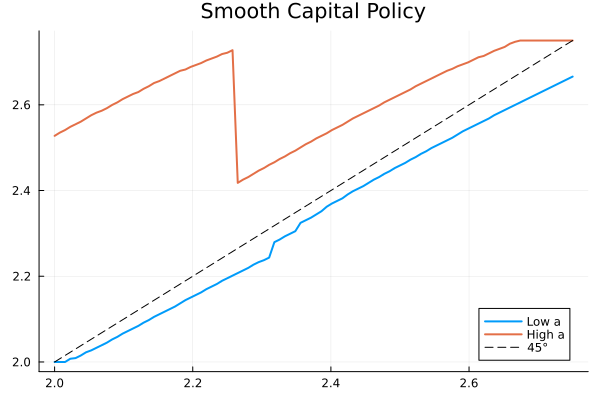

In [10]:
using Plots, LinearAlgebra, Interpolations

# 1. Setup Parameters
const β, α, δ, γ, ψ = 0.99, 0.36, 0.1, 2.0, 1.5
k_grid = collect(range(2.0, 2.75, length=100)) # Fewer points needed with interpolation!
a_grid = [0.9, 1.1]

function solve_smooth_vfi()
    V = zeros(length(k_grid), 2)
    policy_k = zeros(length(k_grid), 2)
    
    for iter in 1:200
        # Create an interpolation object of the current Value Function
        # This allows us to evaluate V(k_next) at ANY point
        V_interp = LinearInterpolation((k_grid, 1:2), V, extrapolation_bc=Line())
        V_new = similar(V)
        
        for (ia, a) in enumerate(a_grid), (ik, k) in enumerate(k_grid)
            w = a * (1 - α) * k^α
            r = a * α * k^(α-1) - δ
            
            # Use a simple optimizer or a finer search for k_next
            # Here we just use a dense candidate search for simplicity
            candidates = range(k_grid[1], k_grid[end], length=500)
            
            best_val = -Inf
            for knext in candidates
                c = w + (1+r)*k - knext
                if c > 0
                    # Standard RBC FOC for labor
                    n = min(1.0, max(0.0, (w * c^-γ)^ψ))
                    util = (c^(1-γ))/(1-γ) - (n^(1+1/ψ))/(1+1/ψ)
                    
                    # Expectation over future a_grid
                    ev = 0.5 * (V_interp(knext, 1) + V_interp(knext, 2))
                    val = util + β * ev
                    
                    if val > best_val
                        best_val = val
                        policy_k[ik, ia] = knext
                    end
                end
            end
            V_new[ik, ia] = best_val
        end
        
        err = maximum(abs.(V_new .- V))
        V .= V_new
        err < 1e-6 && break
    end
    return V, policy_k
end

V_smooth, pol_k = solve_smooth_vfi()

# Plotting
p = plot(k_grid, pol_k[:, 1], label="Low a", title="Smooth Capital Policy", lw=2)
plot!(p, k_grid, pol_k[:, 2], label="High a", lw=2)
plot!(p, k_grid, k_grid, ls=:dash, color=:black, label="45°")

## 2. Real Business Cycle (RBC) style model with endogeneous employment and matching technology

Iteration 10, Error: 0.3570987029794406
Iteration 20, Error: 0.2633917577771987
Iteration 30, Error: 0.2382067844387601
Iteration 40, Error: 0.21542994599190024
Iteration 50, Error: 0.18340101727326186
Iteration 60, Error: 0.14802993751274052
Iteration 70, Error: 0.12677144433396315
Iteration 80, Error: 0.10943249459354831
Iteration 90, Error: 0.09559167465458884
Iteration 100, Error: 0.08508891353867298
Iteration 110, Error: 0.07422275077650298
Iteration 120, Error: 0.0667278385809027
Iteration 130, Error: 0.05858573016163149
Iteration 140, Error: 0.05290467366948093
Iteration 150, Error: 0.04720881036503144
Iteration 160, Error: 0.041953565928668723
Iteration 170, Error: 0.037914512799723354
Iteration 180, Error: 0.03428890410980756
Iteration 190, Error: 0.031007595703144375
Iteration 200, Error: 0.027461899489946262
Iteration 210, Error: 0.024671391584508484
Iteration 220, Error: 0.02230825679451698
Iteration 230, Error: 0.020175148942236376
Iteration 240, Error: 0.01824604285145881

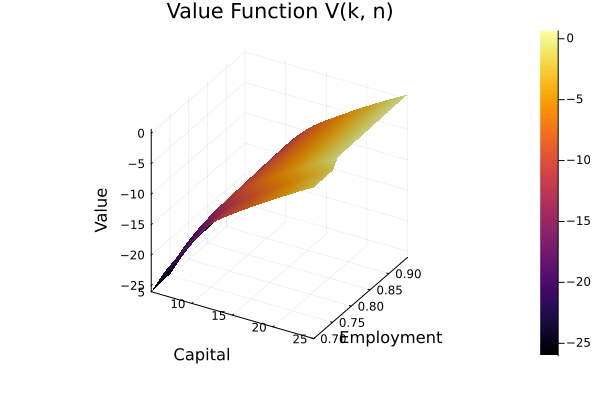

In [2]:
using Plots
using LinearAlgebra

# --- Parameters ---
const β = 0.99          # Discount factor
const α = 0.36          # Capital share
const δ = 0.025         # Depreciation
const σ = 0.15          # Job separation rate
const χ = 0.5           # Matching efficiency
const η = 0.5           # Matching elasticity (unemployment weight)
const κ = 0.2           # Cost of posting a vacancy
const h = 0.45          # Fixed hours worked per employee (Andolfatto assumes fixed hours or bargaining)

# --- Grid Dimensions ---
const N_k = 40          # Capital grid
const N_n = 40          # Employment grid (THE NEW STATE)
const N_a = 2           # Shocks

# --- Grids ---
k_grid = range(5.0, 25.0, length=N_k)
n_grid = range(0.7, 0.95, length=N_n) # Employment rate grid
a_grid = [0.98, 1.02]
prob_a = [0.5 0.5; 0.5 0.5] # Simple symmetric transition

function solve_andolfatto()
    V = zeros(N_k, N_n, N_a)
    V_new = similar(V)
    policy_v = zeros(N_k, N_n, N_a) # Policy: Vacancies
    policy_k = zeros(N_k, N_n, N_a) # Policy: Capital
    
    err = 1.0
    tol = 1e-4
    iter = 0

    while err > tol && iter < 500
        iter += 1
        for ia in 1:N_a, in in 1:N_n, ik in 1:N_k
            a = a_grid[ia]
            n = n_grid[in]
            k = k_grid[ik]
            u = 1.0 - n  # Unemployed pool
            
            max_v = -Inf
            best_vk = (0.0, 0.0)

            # Output produced by current matches
            y = a * (k^α) * (n * h)^(1-α)
            
            # Optimization over v (vacancies) and k_next
            # Note: In a full VFI, we would search over a grid for v and k_next
            for ik_next in 1:N_k
                k_next = k_grid[ik_next]
                
                # Try a range of vacancies
                for v in 0.0:0.02:0.2
                    # 1. Matching Physics
                    m = χ * (u^η) * (v^(1-η))
                    n_next = (1-σ)*n + m
                    
                    # Ensure n_next stays within grid bounds
                    n_next = clamp(n_next, n_grid[1], n_grid[end])
                    
                    # 2. Consumption
                    # Resource Constraint: C = Y + (1-δ)K - K_next - κ*V
                    c = y + (1-δ)*k - k_next - κ*v
                    
                    if c > 0
                        # Interpolate V at n_next (Simple nearest neighbor for this example)
                        in_next = searchsortedfirst(n_grid, n_next)
                        in_next = clamp(in_next, 1, N_n)
                        
                        expected_V = 0.0
                        for ja in 1:N_a
                            expected_V += prob_a[ia, ja] * V[ik_next, in_next, ja]
                        end
                        
                        val = log(c) + β * expected_V
                        
                        if val > max_v
                            max_v = val
                            V_new[ik, in, ia] = val
                        end
                    end
                end
            end
        end
        err = maximum(abs.(V_new - V))
        V .= V_new
        if iter % 10 == 0 println("Iteration $iter, Error: $err") end
    end
    return V, n_grid, k_grid
end

V_final, n_gr, k_gr = solve_andolfatto()

# Plotting the Value Function for a fixed shock
plot(k_gr, n_gr, V_final[:,:,2]', st=:surface, title="Value Function V(k, n)",
     xlabel="Capital", ylabel="Employment", zlabel="Value")

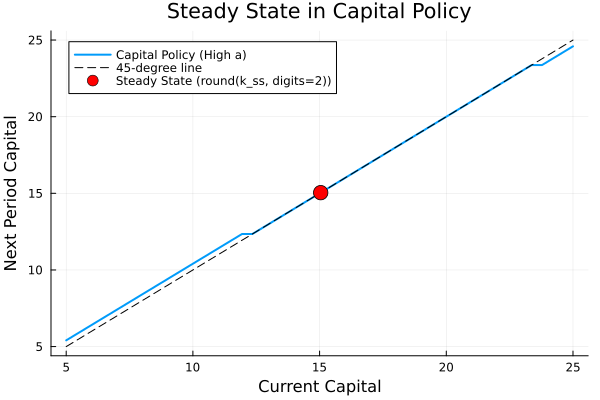

In [3]:
using Plots
using LinearAlgebra

# --- Parameters ---
const β = 0.99          # Discount factor
const α = 0.36          # Capital share
const δ = 0.025         # Depreciation
const σ = 0.15          # Job separation rate
const χ = 0.5           # Matching efficiency
const η = 0.5           # Matching elasticity
const κ = 0.2           # Cost of posting a vacancy
const h = 0.45          # Fixed hours worked

# --- Grid Dimensions ---
const N_k = 50          
const N_n = 50          
const N_a = 2           

# --- Grids ---
k_grid = range(5.0, 25.0, length=N_k)
n_grid = range(0.7, 0.95, length=N_n) 
a_grid = [0.98, 1.02]
prob_a = [0.5 0.5; 0.5 0.5]

# --- Steady State Calculation (Approximation for a=1) ---
# n* is roughly where m(u,v) = σn. 
# For visualization, we calculate the SS capital for a target n* ≈ 0.85
n_ss = 0.88 
# k* from r = 1/β - 1 + δ where r = α * k^(α-1) * (n*h)^(1-α)
k_ss = (( (1/β - 1 + δ) / α ) * (n_ss * h)^(α-1))^(1/(α-1))

function solve_andolfatto()
    V = zeros(N_k, N_n, N_a)
    V_new = similar(V)
    pol_k = zeros(N_k, N_n, N_a) 
    
    err = 1.0
    tol = 1e-4
    iter = 0

    while err > tol && iter < 200
        iter += 1
        for ia in 1:N_a, in in 1:N_n, ik in 1:N_k
            a, n, k = a_grid[ia], n_grid[in], k_grid[ik]
            u = 1.0 - n
            max_v = -Inf
            
            y = a * (k^α) * (n * h)^(1-α)
            
            for ik_next in 1:N_k
                k_next = k_grid[ik_next]
                for v in 0.0:0.05:0.25 # Coarser vacancy grid for speed
                    m = χ * (u^η) * (v^(1-η))
                    n_next = clamp((1-σ)*n + m, n_grid[1], n_grid[end])
                    c = y + (1-δ)*k - k_next - κ*v
                    
                    if c > 0
                        in_next = clamp(searchsortedfirst(n_grid, n_next), 1, N_n)
                        expected_V = sum(prob_a[ia, :] .* V[ik_next, in_next, :])
                        val = log(c) + β * expected_V
                        
                        if val > max_v
                            max_v = val
                            V_new[ik, in, ia] = val
                            pol_k[ik, in, ia] = k_next
                        end
                    end
                end
            end
        end
        err = maximum(abs.(V_new - V))
        V .= V_new
    end
    return V, pol_k
end

V_final, pol_k = solve_andolfatto()

# --- Final Plotting ---
# We plot the Capital Policy Function k' = g(k, n_ss)
idx_n_ss = searchsortedfirst(n_grid, n_ss)

p1 = plot(k_grid, pol_k[:, idx_n_ss, 2], label="Capital Policy (High a)", 
          lw=2, title="Steady State in Capital Policy", xlabel="Current Capital", ylabel="Next Period Capital")
plot!(p1, k_grid, k_grid, label="45-degree line", linestyle=:dash, color=:black)
scatter!(p1, [k_ss], [k_ss], color=:red, markersize=8, label="Steady State ($round(k_ss, digits=2))")

display(p1)